###Imports and connect to drive

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from google.colab import files

import math # has mathsy functions
from sklearn.linear_model import LinearRegression # is the package to build the linear regression model
from sklearn import metrics # contains functions for module evaluation
from sklearn.model_selection import train_test_split # module to split our data into train and test sets


import statsmodels.api as sm
import statsmodels.tools

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Build data frame
Also change column types to integers

Drop rows that have only a few nulls for columns with few null values

Drop useless columns

In [37]:
file_path = 'drive/MyDrive/Colab Notebooks/BMW'

filename_list = [filename for filename in os.listdir(file_path)]

dfs = []
'''
for filename in filename_list:
    my_df = pd.read_csv(file_path+'/'+filename)
    my_df['filename'] = filename
    dfs.append(my_df)'''

for filename in filename_list:
    my_df = pd.read_csv(file_path+'/'+filename)
    my_df['filename'] = filename
    df_in = pd.DataFrame(my_df)
    df_in['name'] = filename[:-4]
    dfs.append(df_in)
    df = pd.concat(dfs, ignore_index=True)

## Change price and engine size columsn to integers
df['price'] = df['price'].str.replace('£','').str.replace(',','')
df = df.astype({'price': int})
df['engine'] = df['engine'].str.replace('L','')
df = df.astype({'engine': float})

df = df.astype({'mileage': float})

# Drop any cars with no year entry, too difficult to predict
df = df.dropna(subset=['year']).reset_index()

# Put year column into usable int value
df['year'] = df['year'].str.replace('(','').str.replace(')','')
df['C.year'] = df['year'].str.split().str.get(0)
df['C.reg'] = df['year'].str.split().str.get(1) + ' ' + df['year'].str.split().str.get(2)
df = df.astype({'C.year': int})
# Rows of 'null' sin mileage, transmission, fuel, body can all be dropped
df = df.dropna(subset=['mileage', 'transmission', 'fuel', 'body']).reset_index(drop=True)
# Drop ULEZ column all together
df= df.drop(['ULEZ', 'filename', 'link','year'], axis=1)
#Remove any rows that have both engine and BHP as null (engine size is strong predictor of BHP)
df = df.dropna(subset=['BHP','engine'], how='all')
df.describe()

<ipython-input-37-78c3b1fc013b>:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['year'] = df['year'].str.replace('(','').str.replace(')','')


,index,price,mileage,BHP,owners,engine,C.year
count,29818.000000,29818.000000,29818.000000,12982.000000,13099.000000,29290.000000,29818.000000
mean,15473.720135,19800.178315,56168.419076,204.187953,2.847317,2.251526,2015.993963
std,8980.987317,11393.833054,36385.169989,69.455458,1.214844,0.568236,3.658067
min,0.000000,750.000000,10.000000,94.000000,2.000000,0.600000,2005.000000
25%,7643.250000,11400.000000,26774.500000,167.000000,2.000000,2.000000,2014.000000
50%,15660.500000,18100.000000,49200.000000,190.000000,2.000000,2.000000,2017.000000
75%,23309.750000,25990.000000,79449.250000,239.500000,3.000000,3.000000,2019.000000
max,30915.000000,114995.000000,398000.000000,610.000000,13.000000,6.600000,2021.000000


In [32]:
df.isnull().sum()

index               0
name                0
price               0
mileage             0
BHP             16836
transmission        0
fuel                0
owners          16719
body                0
engine            528
C.year              0
C.reg               0
dtype: int64

### Predict BHP using linear regression

Engine, body, fuel, year and transmission an be used as features

In [19]:
# Simple linear regression model using sklearn
def simp_model_sk(dataframe, Xparams, yparam):

    feature_cols = Xparams

    X = dataframe[feature_cols]
    y = dataframe[[yparam]]

    lin_reg = LinearRegression()
    results = lin_reg.fit(X, y)
    dataframe['y_pred'] = results.predict(X)

    rmse = (metrics.mean_squared_error(y, dataframe['y_pred']))**0.5

    labeled = list(zip(feature_cols, lin_reg.coef_))
    print(f'the RMSE is {rmse}')
    print(f'The intercept is {lin_reg.intercept_}')
    print(f'The coefficients are: {labeled}')
    return results

Encode the categorical columns that contribute to BHP

In [33]:
df_enc_body = pd.get_dummies(df, columns = ['body'], drop_first = False, prefix = 'body')
df_enc_body_fuel = pd.get_dummies(df_enc_body, columns = ['fuel'], drop_first = False, prefix = 'fuel')
df_enc_body_fuel_trans = pd.get_dummies(df_enc_body_fuel, columns = ['transmission'], drop_first = False, prefix = 'trans')
#Create list of encoded column titles
df_enc_body_fuel_trans.columns
df_enc_body_fuel_trans.head(5)

,index,name,price,mileage,BHP,owners,engine,C.year,C.reg,body_Convertible,...,body_SUV,body_Saloon,fuel_Diesel,fuel_Diesel Hybrid,fuel_Electric,fuel_Petrol,fuel_Petrol Hybrid,fuel_Petrol Plug-in Hybrid,trans_Automatic,trans_Manual
0,0,BMW_2 Series Gran Coupe,32750,32000.0,NaN,NaN,2.0,2020,70 reg,0,...,0,1,0,0,0,1,0,0,1,0
1,1,BMW_2 Series Gran Coupe,29990,29816.0,NaN,NaN,2.0,2020,20 reg,0,...,0,1,0,0,0,1,0,0,1,0
2,2,BMW_2 Series Gran Coupe,23000,29500.0,NaN,NaN,1.5,2020,70 reg,0,...,0,1,0,0,0,1,0,0,0,1
3,3,BMW_2 Series Gran Coupe,21599,22592.0,136.0,NaN,1.5,2020,20 reg,0,...,0,1,0,0,0,1,0,0,0,1
4,4,BMW_2 Series Gran Coupe,22099,33123.0,138.0,NaN,1.5,2020,70 reg,0,...,0,1,0,0,0,1,0,0,0,1


the RMSE is 30.75157001076328
The intercept is [-9.27280497e+13]
The coefficients are: [('engine', array([1.26353900e+02, 4.26142014e+13, 4.26142014e+13, 4.26142014e+13,
       4.26142014e+13, 4.26142014e+13, 4.26142014e+13, 4.26142014e+13,
       4.47544570e+13, 4.47544570e+13, 4.47544570e+13, 4.47544570e+13,
       4.47544570e+13, 4.47544570e+13, 5.35939125e+12, 5.35939125e+12,
       2.60843598e+00]))]


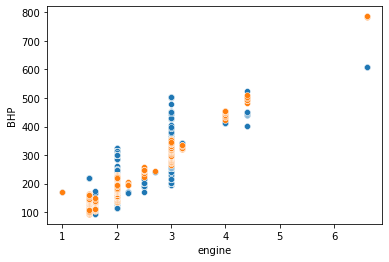

In [34]:
feature_cols = ['engine', 'body_Convertible', 'body_Coupe', 'body_Estate',
                'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon', 'fuel_Diesel',
                'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
                'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Automatic',
                'trans_Manual','C.year']
df_enc_nonull = df_enc_body_fuel_trans.dropna(subset=['BHP','engine']).reset_index()

lin_model = simp_model_sk(df_enc_nonull,feature_cols,'BHP')
bhp_pred = pd.DataFrame(lin_model.predict(df_enc_nonull.loc[:,feature_cols]))
sns.scatterplot(x = 'engine',
                y = 'BHP',
                data = df)
sns.scatterplot(x = df_enc_nonull['engine'],
                y = bhp_pred.iloc[:,0])
plt.show()

Replace the BHP null values with predicted BHP values

In [36]:
df.isnull().sum()

index               0
name                0
price               0
mileage             0
BHP                 0
transmission        0
fuel                0
owners          16719
body                0
engine            528
C.year              0
C.reg               0
dtype: int64

In [35]:
# Create a DF of the predicted BHP values, for rows where BHP is null
BHP_null_predict = pd.DataFrame(lin_model.predict(df_enc_body_fuel_trans[df_enc_body_fuel_trans['BHP'].isnull()][feature_cols])[:,0])
# Get the indexes of all the null BHP values
BHP_null_idx = df[df['BHP'].isnull()][['BHP']].index
# Set index of predicted values to match the index of BHP nulls, also squeeze it to use in 'fillna'
BHP_null_predict = BHP_null_predict.set_index(BHP_null_idx).squeeze()
# In the BHP column replace null values with the predictions
df['BHP'] = df['BHP'].fillna(BHP_null_predict)
df.isnull().sum()

index               0
name                0
price               0
mileage             0
BHP                 0
transmission        0
fuel                0
owners          16719
body                0
engine            528
C.year              0
C.reg               0
dtype: int64

### Addressing other null values
Replace owner nulls using the mode of owners from each year

In [23]:
# Get the modes of owner from year
owner_modes = df[['C.year','owners']].groupby('C.year').agg(pd.Series.mode)
## Merge the two data frames. 
df = df.merge(owner_modes, how='left', left_on=['C.year',], right_on=['C.year'])
# Drop ULEZ column all together
df= df.drop(['owners_x'], axis=1)
df.rename(columns={'owners_y':'owners'}, inplace=True)
df.isnull().sum()

index             0
name              0
price             0
mileage           0
BHP               0
transmission      0
fuel              0
body              0
engine          528
C.year            0
C.reg             0
owners            0
dtype: int64

Drop any null engine values as they come from the I3 model which is electric

In [24]:
# Remove null values form engine for now
df = df.dropna(subset=['engine']).reset_index(drop=True)
df.isnull().sum()

index           0
name            0
price           0
mileage         0
BHP             0
transmission    0
fuel            0
body            0
engine          0
C.year          0
C.reg           0
owners          0
dtype: int64

### Predicting price with linear regression

Nearly all the columns can be used for features

In [ ]:
'''import re

df['name'] = df['name'].str.strip()
df['name'] = df['name'].str.upper()
df_groups = df

df_groups['name'] = [(lambda x: 'BMW 1 Series' if (re.match(r'^BMW 1', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW 2 Series' if (re.match(r'^BMW 2 [^GRAN]', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW 2 Series Gran' if (re.match(r'^BMW 2 [GRAN]', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW 3 Series' if (re.match(r'^BMW 3', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW 4 Series' if (re.match(r'^BMW 4', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW 5 Series' if (re.match(r'^BMW 5', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW 7 Series' if (re.match(r'^BMW 7', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW X1 Series' if (re.match(r'^BMW X1', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW X2 Series' if (re.match(r'^BMW X2', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW X3 Series' if (re.match(r'^BMW X3', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW X5 Series' if (re.match(r'^BMW X5', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW X6 Series' if (re.match(r'^BMW X6', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW Z4' if (re.match(r'^BMW Z', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW I3' if (re.match(r'^BMW I', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW M3' if (re.match(r'^BMW M[1*2*3*]', x)) else x)(x) for x in df_groups['name']]
df_groups['name'] = [(lambda x: 'BMW M4' if (re.match(r'^BMW M4', x)) else x)(x) for x in df_groups['name']]

df_groups[['name','price']].groupby('name').count()'''



"import re\n\ndf['name'] = df['name'].str.strip()\ndf['name'] = df['name'].str.upper()\ndf_groups = df\n\ndf_groups['name'] = [(lambda x: 'BMW 1 Series' if (re.match(r'^BMW 1', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW 2 Series' if (re.match(r'^BMW 2 [^GRAN]', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW 2 Series Gran' if (re.match(r'^BMW 2 [GRAN]', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW 3 Series' if (re.match(r'^BMW 3', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW 4 Series' if (re.match(r'^BMW 4', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW 5 Series' if (re.match(r'^BMW 5', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW 7 Series' if (re.match(r'^BMW 7', x)) else x)(x) for x in df_groups['name']]\ndf_groups['name'] = [(lambda x: 'BMW X1 Series' if (re.match(r'^BMW X

Remove rows for the single entry names

In [ ]:
'''singles_idx = df[(df['name']=='BMW RANGE ROVER SPORT') | (df['name']=='BMW M SERIES') | (df['name']=='BMW C-CLASS')| (df['name']=='BMW I3')].index
df.drop(singles_idx, inplace=True)
df_groups[['name','price']].groupby('name').count()'''

"singles_idx = df[(df['name']=='BMW RANGE ROVER SPORT') | (df['name']=='BMW M SERIES') | (df['name']=='BMW C-CLASS')| (df['name']=='BMW I3')].index\ndf.drop(singles_idx, inplace=True)\ndf_groups[['name','price']].groupby('name').count()"

Encode the name categories, output the column names to use as features

In [25]:
df_enc_body = pd.get_dummies(df, columns = ['body'], drop_first = False, prefix = 'body')
df_enc_body_fuel = pd.get_dummies(df_enc_body, columns = ['fuel'], drop_first = False, prefix = 'fuel')
df_enc_body_fuel_trans = pd.get_dummies(df_enc_body_fuel, columns = ['transmission'], drop_first = False, prefix = 'trans')
df_enc_full = pd.get_dummies(df_enc_body_fuel_trans, columns = ['name'], drop_first = False, prefix = 'name')
#Create list of encoded column titles
df_enc_full.columns
#df_enc_full.head(5)

Index(['index', 'price', 'mileage', 'BHP', 'engine', 'C.year', 'C.reg',
       'owners', 'body_Convertible', 'body_Coupe', 'body_Estate',
       'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon', 'fuel_Diesel',
       'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
       'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Automatic',
       'trans_Manual', 'name_BMW_1 Series', 'name_BMW_2 Series',
       'name_BMW_2 Series Active Tourer', 'name_BMW_2 Series Gran Coupe',
       'name_BMW_3 Series', 'name_BMW_4 Series',
       'name_BMW_4 Series Gran Coupe', 'name_BMW_5 Series',
       'name_BMW_7 Series', 'name_BMW_I3', 'name_BMW_M3', 'name_BMW_M4',
       'name_BMW_X1', 'name_BMW_X2', 'name_BMW_X3', 'name_BMW_X5',
       'name_BMW_X6', 'name_BMW_Z4'],
      dtype='object')

In [26]:
feature_cols = ['mileage', 'BHP', 'owners', 'engine',
        'C.year','body_Convertible', 'body_Coupe', 'body_Estate',
       'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon', 'fuel_Diesel',
       'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
       'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Automatic',
       'trans_Manual', 'name_BMW_1 Series', 'name_BMW_2 Series',
       'name_BMW_2 Series Active Tourer', 'name_BMW_2 Series Gran Coupe',
       'name_BMW_3 Series', 'name_BMW_4 Series',
       'name_BMW_4 Series Gran Coupe', 'name_BMW_5 Series',
       'name_BMW_7 Series', 'name_BMW_I3', 'name_BMW_M3', 'name_BMW_M4',
       'name_BMW_X1', 'name_BMW_X2', 'name_BMW_X3', 'name_BMW_X5',
       'name_BMW_X6', 'name_BMW_Z4']

lin_model = simp_model_sk(df_enc_full,feature_cols,'price')

the RMSE is 4136.985089954318
The intercept is [-4046357.78097654]
The coefficients are: [('mileage', array([-7.87609302e-02,  1.69520707e+01,  2.42693945e+03,  1.73013795e+03,
        2.01445844e+03, -1.14059318e+02,  3.35565754e+02,  1.00653577e+03,
       -3.60582720e+03,  9.30127192e+02,  1.87271895e+03, -4.25061154e+02,
       -2.72264505e+03,  2.48777227e+03, -1.18333226e+03, -2.49684095e+03,
        3.96543224e+03, -5.03862529e+01,  3.14245557e+02, -3.14245557e+02,
       -6.92387901e+02, -5.81185349e+03, -8.18916312e+03, -1.96538373e+03,
       -2.17882729e+03, -2.59700021e+03,  1.17277428e+02, -1.41486624e+03,
        4.21518608e+03, -2.22000571e+03,  1.14480715e+04,  7.71491483e+03,
       -4.60197315e+03, -5.54152567e+03,  4.73712382e+01,  6.21653707e+03,
        5.75230947e+03, -2.98681109e+02]))]


In [27]:
X = df_enc_full[feature_cols]
y = df_enc_full['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X = X_train
y = y_train

lin_reg = sm.OLS(y_train, X_train[feature_cols])
results = lin_reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     4757.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:57:53   Log-Likelihood:            -2.2834e+05
No. Observations:               23432   AIC:                         4.568e+05
Df Residuals:                   23398   BIC:                         4.570e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
mileage                            -0.0788      0.001    -67.943      0.000      -0.081      -0.077
BHP                                17.4132      1.455     11.966      0.000      14.561      20.266
owners                           2443.9273     58.221     41.976      0.000    2329.810    2558.045
engine                           1690.4511    189.215      8.934      0.000    1319.578    2061.324
C.year                           2010.1622     15.114    133.004      0.000    1980.539    2039.786
body_Convertible                -6.438e+05   4898.252   -131.425      0.000   -6.53e+05   -6.34e+05
body_Coupe                      -6.433e+05   4903.128   -131.199      0.000   -6.53e+05   -6.34e+05
body_Estate                     -6.427e+05   4938.847   -130.125      0.000   -6.52e+05   -6.33e+05
body_Hatchback                  -6.471e+05   4943.668   -130.903      0.000   -6.57e+05   -6.37e+05
body_MPV                        -6.427e+05   6000.155   -107.112      0.000   -6.54e+05   -6.31e+05
body_SUV                         -7.82e+05   5957.816   -131.248      0.000   -7.94e+05    -7.7e+05
body_Saloon                     -6.441e+05   4933.678   -130.549      0.000   -6.54e+05   -6.34e+05
fuel_Diesel                     -7.771e+05   5873.627   -132.297      0.000   -7.89e+05   -7.66e+05
fuel_Diesel Hybrid              -7.718e+05   5910.061   -130.593      0.000   -7.83e+05    -7.6e+05
fuel_Electric                   -7.754e+05   6441.427   -120.379      0.000   -7.88e+05   -7.63e+05
fuel_Petrol                     -7.768e+05   5871.221   -132.305      0.000   -7.88e+05   -7.65e+05
fuel_Petrol Hybrid              -7.701e+05   5901.631   -130.498      0.000   -7.82e+05   -7.59e+05
fuel_Petrol Plug-in Hybrid      -7.743e+05   5885.912   -131.558      0.000   -7.86e+05   -7.63e+05
trans_Automatic                 -2.322e+06   1.76e+04   -131.824      0.000   -2.36e+06   -2.29e+06
trans_Manual                    -2.323e+06   1.76e+04   -131.922      0.000   -2.36e+06   -2.29e+06
name_BMW_1 Series               -2.978e+05   2276.972   -130.779      0.000   -3.02e+05   -2.93e+05
name_BMW_2 Series               -3.029e+05   2311.624   -131.013      0.000   -3.07e+05   -2.98e+05
name_BMW_2 Series Active Tourer -3.053e+05   4424.462    -68.995      0.000   -3.14e+05   -2.97e+05
name_BMW_2 Series Gran Coupe    -2.989e+05   2324.179   -128.626      0.000   -3.04e+05   -2.94e+05
name_BMW_3 Series               -2.992e+05   2279.568   -131.235      0.000   -3.04e+05   -2.95e+05
name_BMW_4 Series               -2.996e+05   2310.910   -129.638      0.000   -3.04e+05   -2.95e+05
name_BMW_4 Series Gran Coupe     -2.97e+05   2290.379   -129.675      0.000   -3.01e+05   -2.93e+05
name_BMW_5 Series               -2.984e+05   2278.891   -130.929      0.000   -3.03

In [28]:
X_train['y_pred'] = results.predict(X_train[feature_cols])

rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['y_pred'])

print(rmse)

4129.929977885784


In [29]:
X_test = X_test[feature_cols]

## Now we predict using the X_test set! 
## We don't "fit" the model again! 
## We want to see test results that are similar to the training results!

X_test['y_pred'] = results.predict(X_test)
rmse = statsmodels.tools.eval_measures.rmse(y_test, X_test['y_pred'])
print(rmse)

4168.167906329299


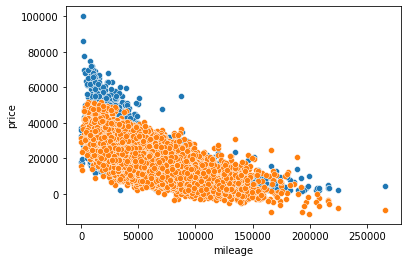

In [30]:
sns.scatterplot(x = X_test['mileage'],
                y = y_test)
sns.scatterplot(x = X_test['mileage'],
                y = X_test['y_pred'])
plt.show()

Further analysis

In [ ]:
## Understanding Multi... collin... eraity more.
## Multicollinearity:
## https://en.wikipedia.org/wiki/Variance_inflation_factor
## https://en.wikipedia.org/wiki/Multicollinearity#:~:text=Multicollinearity%20refers%20to%20a%20situation,equal%20to%201%20or%20%E2%88%921.

from statsmodels.stats.outliers_influence import variance_inflation_factor # a module to evaluate the variance inflation factor (VIF)
feature_cols = ['mileage', 'BHP', 'owners', 'engine',
        'C.year','body_Convertible', 'body_Coupe', 'body_Estate',
       'body_Hatchback', 'body_MPV', 'body_SUV', 'body_Saloon', 'fuel_Diesel',
       'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
       'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Automatic',
       'trans_Manual', 'name_BMW_1 Series', 'name_BMW_2 Series',
       'name_BMW_2 Series Active Tourer', 'name_BMW_2 Series Gran Coupe',
       'name_BMW_3 Series', 'name_BMW_4 Series',
       'name_BMW_4 Series Gran Coupe', 'name_BMW_5 Series',
       'name_BMW_7 Series', 'name_BMW_I3', 'name_BMW_M3', 'name_BMW_M4',
       'name_BMW_X1', 'name_BMW_X2', 'name_BMW_X3', 'name_BMW_X5',
       'name_BMW_X6', 'name_BMW_Z4']
## We can create an indexed list (a series) where we list the VIF of each of the columns. Note the use of '.shape' in the second part of the loop
pd.Series([variance_inflation_factor(X_train[feature_cols].values, i) for i in range(X_train[feature_cols].shape[1])], index = X_train[feature_cols].columns)


mileage      4.560082
BHP         80.438753
owners      14.286109
engine     149.219055
C.year      26.854230
dtype: float64

In [ ]:
## This a piece of code from stats.stackexchange.com

## It runs the model with all of the variables. 
## If any of them have a higher VIF than 5, it drops the max. 
## Then it keeps going until none of them have a higher VIF than 5.
## This leaves us with a nice set of features with no collineraity

def calculate_vif(X, thresh = 5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        
        maxloc = vif.index(max(vif)) # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables]) # finally, we print the variables that are still in our set
    #return X.iloc[:, variables] # and return our X cut down to the remaining variables

calculate_vif(X_train[feature_cols])

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'body_Convertible' at index: 5
dropping 'body_SUV' at index: 9
dropping 'fuel_Diesel' at index: 10
dropping 'trans_Automatic' at index: 15
dropping 'name_BMW_3 Series' at index: 20
dropping 'name_BMW_2 Series Active Tourer' at index: 18
dropping 'engine' at index: 3
dropping 'C.year' at index: 3
dropping 'BHP' at index: 1
dropping 'body_Hatchback' at index: 4
dropping 'owners' at index: 1
Remaining variables:
Index(['mileage', 'body_Coupe', 'body_Estate', 'body_MPV', 'body_Saloon',
       'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
       'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Manual',
       'name_BMW_1 Series', 'name_BMW_2 Series',
       'name_BMW_2 Series Gran Coupe', 'name_BMW_4 Series',
       'name_BMW_4 Series Gran Coupe', 'name_BMW_5 Series',
       'name_BMW_7 Series', 'name_BMW_I3', 'name_BMW_M3', 'name_BMW_M4',
       'name_BMW_X1', 'name_BMW_X2', 'name_BMW_X3', 'name_BMW_X5',
       'name_BMW_X6', 'name_BMW_Z4'],
      dtype='object')

In [15]:
feature_cols_lowVIF = ['mileage', 'body_Coupe', 'body_Estate', 'body_MPV', 'body_Saloon',
       'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
       'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Manual',
       'name_BMW_1 Series', 'name_BMW_2 Series',
       'name_BMW_2 Series Gran Coupe', 'name_BMW_4 Series',
       'name_BMW_4 Series Gran Coupe', 'name_BMW_5 Series',
       'name_BMW_7 Series', 'name_BMW_I3', 'name_BMW_M3', 'name_BMW_M4',
       'name_BMW_X1', 'name_BMW_X2', 'name_BMW_X3', 'name_BMW_X5',
       'name_BMW_X6', 'name_BMW_Z4']
## We can create an indexed list (a series) where we list the VIF of each of the columns. Note the use of '.shape' in the second part of the loop
pd.Series([variance_inflation_factor(X_train[feature_cols_lowVIF].values, i) for i in range(X_train[feature_cols_lowVIF].shape[1])], index = X_train[feature_cols_lowVIF].columns)


NameError: ignored

6729.8236372187785
6705.061783151007


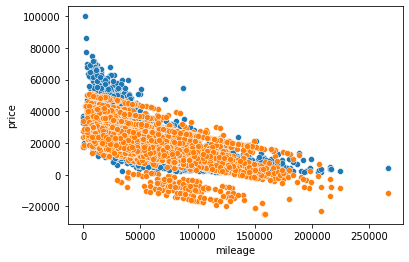

In [ ]:
X = df_enc_full[feature_cols]
y = df_enc_full['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X = X_train
y = y_train

lin_reg = sm.OLS(y_train, X_train[feature_cols])
results = lin_reg.fit()

X_train['y_pred'] = results.predict(X_train[feature_cols])

rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['y_pred'])

print(rmse)

X_test = X_test[feature_cols]

## Now we predict using the X_test set! 
## We don't "fit" the model again! 
## We want to see test results that are similar to the training results!

X_test['y_pred'] = results.predict(X_test)
rmse = statsmodels.tools.eval_measures.rmse(y_test, X_test['y_pred'])
print(rmse)

sns.scatterplot(x = X_test['mileage'],
                y = y_test)
sns.scatterplot(x = X_test['mileage'],
                y = X_test['y_pred'])
plt.show()

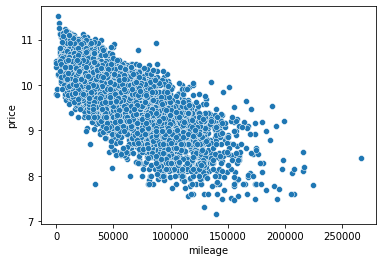

In [ ]:
sns.scatterplot(x = X_test['mileage'],
                y = np.log(y_test))

1.1732972192767441
1.1739495553311605


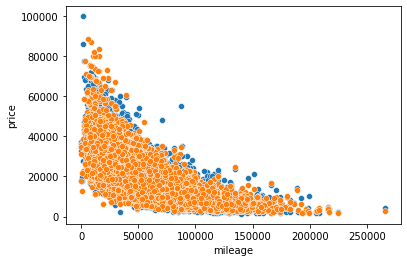

In [ ]:
X = df_enc_full[feature_cols]
y = np.log(df_enc_full['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lin_reg = sm.OLS(y_train, X_train[feature_cols])
results = lin_reg.fit()

X_train['y_pred'] = results.predict(X_train[feature_cols])

rmse = np.exp(statsmodels.tools.eval_measures.rmse(y_train, X_train['y_pred']))

print(rmse)

X_test = X_test[feature_cols]

## Now we predict using the X_test set! 
## We don't "fit" the model again! 
## We want to see test results that are similar to the training results!

X_test['y_pred'] = results.predict(X_test)
rmse = np.exp(statsmodels.tools.eval_measures.rmse(y_test, X_test['y_pred']))
print(rmse)

sns.scatterplot(x = X_test['mileage'],
                y = np.exp(y_test))
sns.scatterplot(x = X_test['mileage'],
                y = np.exp(X_test['y_pred']))
plt.show()

1.3472308073861234
1.3465582250652977


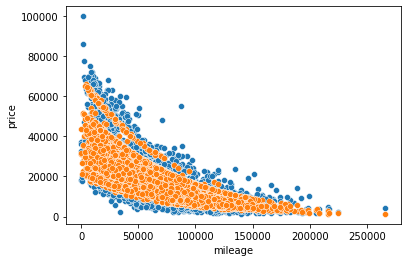

In [17]:
feature_cols_lowVIF = ['mileage',
        'body_Coupe', 'body_Estate', 'body_MPV', 'body_Saloon',
       'fuel_Diesel', 'fuel_Diesel Hybrid', 'fuel_Electric', 'fuel_Petrol',
       'fuel_Petrol Hybrid', 'fuel_Petrol Plug-in Hybrid', 'trans_Manual',
       'name_BMW_1 Series', 'name_BMW_2 Series',
       'name_BMW_2 Series Gran Coupe', 'name_BMW_4 Series',
       'name_BMW_4 Series Gran Coupe', 'name_BMW_5 Series',
       'name_BMW_7 Series', 'name_BMW_I3', 'name_BMW_M3', 'name_BMW_M4',
       'name_BMW_X1', 'name_BMW_X2', 'name_BMW_X3', 'name_BMW_X5',
       'name_BMW_X6', 'name_BMW_Z4']

X = df_enc_full[feature_cols_lowVIF]
y = np.log(df_enc_full['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lin_reg = sm.OLS(y_train, X_train[feature_cols_lowVIF])
results = lin_reg.fit()

X_train['y_pred'] = results.predict(X_train[feature_cols_lowVIF])

rmse = np.exp(statsmodels.tools.eval_measures.rmse(y_train, X_train['y_pred']))

print(rmse)

X_test = X_test[feature_cols_lowVIF]

## Now we predict using the X_test set! 
## We don't "fit" the model again! 
## We want to see test results that are similar to the training results!

X_test['y_pred'] = results.predict(X_test)
rmse = np.exp(statsmodels.tools.eval_measures.rmse(y_test, X_test['y_pred']))
print(rmse)

sns.scatterplot(x = X_test['mileage'],
                y = np.exp(y_test))
sns.scatterplot(x = X_test['mileage'],
                y = np.exp(X_test['y_pred']))
plt.show()